In [64]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

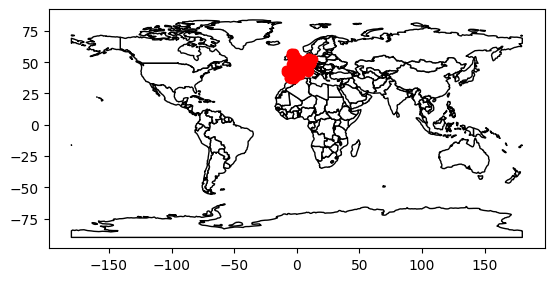

In [7]:
# Day 1 - Points
# https://github.com/jokecamp/FootballData/blob/master/other/stadiums-with-GPS-coordinates.csv

# Read the CSV file
df = pd.read_csv("data/stadiums-with-GPS-coordinates.csv")

# Create a GeoDataFrame from the CSV data
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Plot the points on a map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


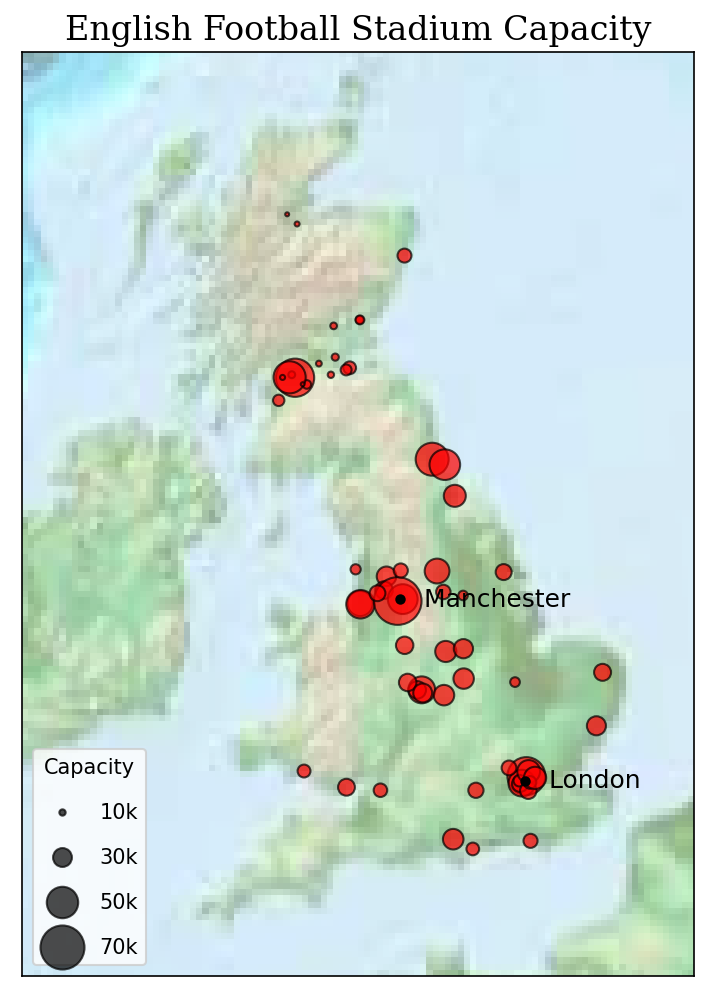

In [116]:
# 1. Draw the map background

fig = plt.figure(figsize=(8, 8), dpi=150)
m = Basemap(projection='lcc', resolution='l',
            width=0.8E6, height=1.1E6, 
            lat_0=54.4, lon_0=-3,)
m.etopo(scale=1, alpha=0.5)

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(gdf.Longitude, gdf.Latitude, latlon=True,
          c='red', s=(30*gdf.Capacity / gdf.Capacity.max())**2,
          alpha=0.7, edgecolors='black')

# make legend with dummy points
for a in [10000, 30000, 50000, 70000]:
    plt.scatter([], [], c='k', alpha=0.7, s=(30*a / gdf.Capacity.max())**2,
                label=str(int(a/1000)) + 'k')
plt.legend(title='Capacity', scatterpoints=1, frameon=True,
           labelspacing=1.2, loc='lower left');
plt.title("English Football Stadium Capacity", fontdict={'family': 'serif', 'size': 16})

# Add cities to map
# Add a point for London with a label
cities = [[-0.1278, 51.5074, '   London'],
          [-2.244644, 53.483959, '   Manchester'],]

for city in cities:
    # Convert lat/lon to map coordinates
    x, y = m(city[0], city[1])
    m.plot(x, y, '.', c='black', markersize=8)
    plt.text(x, y, city[2], fontsize=12, alpha=1, c='black', verticalalignment='center')
